# Projection On Ellipsoid

in this notebook we will take ellipses as our convex set's which is a little hard to project on an ellipse . 
let us describe an ellipse $C = \{Au+b \:| \: ||u|| \le 1 , u \in \mathbf{R}^{n} \}$ and for projection we will need to optimize :

$$P_{C}(x) = arg\min_{||u|| \le 1}{\:||\: Au+b - x \:||} $$

please notice that $A$ is a definite positive matrix . i am afraid to say that there is no analytic solution to the minimization above but hopefully we have CVX !! 
if we solve the dual problem we then see that $ 0 = A^{T}(Au+b-x) + \lambda u $ and then $ u = (A^{T}A+\lambda I)^{-1}A^{T}(x-b) $ and also we must have $||u|| = 1$ from KKT conditions so we need to find $\lambda$ such that this constraint satisfy . let us define $A = UDU^{T} $ (because $A$ is positive definite symmetric matrix) where $U$ is unitary matrix and $D$ is diagonal where all of it's diagonal elements are positive !

then we have $u = U(D^2 + \lambda I)^{-1}DU^{T}(x-b) $ then if we take $v = U^{T}(x-b)$ we have $||u||^2 = v^{T}D^2(D^2+\lambda I)^{-2} v = \sum_{i=1}^{n}{\frac{\sigma_{i}^{2}}{(\sigma_{i}^{2}+\lambda)^2}v_{i}^2} = 1 $ where this a convex and decreasing function with respect to $\lambda$ 

In [141]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import animation as anim
from IPython.display import HTML
import numpy as np
from scipy.optimize import newton

In [169]:
# n ellipses
n = 2
# we are in 2-D dimenstion !
A = [np.random.randn(2,2) for _ in range(n)]
A = [np.dot(ell,ell.T) for ell in A]
b = [np.random.rand(2,1)*0.5 for _ in range(n)]
x = np.array([-3,-2]).reshape((2,1))

In [170]:
def project_on_ellipse(x , A , b):
    """
    x : the point
    A : ellipse covariance
    b : ellipse center
    ----------------------
    retrun : point on ellipse
    
    """
    # check the point is inside or not
    U , sigma , _ = np.linalg.svd(A)
    v = np.dot(U.T,x-b).reshape(-1)
    func = lambda Lambda : (sigma**2 /(sigma**2 + Lambda)**2 * (v**2)).sum() -1 
    if func(0) < 0 :
        # the point is inside the ellipse
        return x
    else:
        x0 = newton(func,0,tol=1e-4)
        u = np.dot(U * (sigma /(sigma**2 + x0)) , v ).reshape((-1,1))
        u = np.dot(A,u) + b
        return u

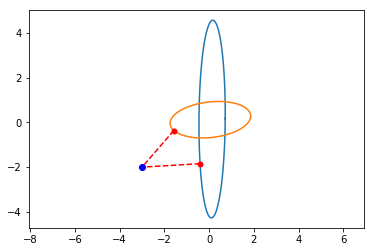

In [171]:
t = np.linspace(0,2*np.pi,100)
ellipses = [np.dot(ell , np.vstack((np.cos(t) , np.sin(t)))) + center for ell , center in zip(A,b)]
for i in range(n):
    plt.plot(ellipses[i][0,:],ellipses[i][1,:])
    u = project_on_ellipse(x , A[i],b[i])
    plt.plot([u[0,0],x[0,0]],[u[1,0],x[1,0]] , 'r--.',markersize=10)
plt.plot(x[0,0],x[1,0],'b.',markersize=12)
plt.axis('equal') ; 

# Projection On Intersection of Convex Sets

in the latter , we've defined $P_C(x)$ which was the projecting point from point $x$ onto convex closed set $C$ .
let us define :

$$ dist(x,C) = ||x-P_C(x)|| $$

this is the distance function which is convex (because it is an infimum of a convex function over a convex set) and differetiable with gradient $\nabla dist(x,C) = \frac{P_C(x)-x}{||x-P_C(x)||} $ for every $x \not\in C $ .( this is because this function is bounded by the function $||y-P_C(x)||$ and is tangent at point $y=x$ so every sub gradient of the distance function must be a sub gradient of this function but this function is differentiable ! so the distance function must have only one sub-gradient and that would be the gradient of this function ) 
as we can see gradient of the distance function has length equal to one for every point not in the set . we could also check that for other points the sub gradient must satisfy :

$$ <g , y-x> \:\le\: ||y-P_C(y)|| \quad , \forall \: y\in \mathbf{R}^n \: , x \in boundary(C) $$

so we can see that $<g,.>$ must be a supporting hyperplane for $C$ at point $x$ which means that $P_C(x+tg) = x $ so if we take $y = x+tg $ we could see that length of $g$ must be less or equal to one which means the distance function is Lipschitz function . now let us define :

$$ f(x) = \max_{i=1...n}{\: dist(x,C_i)} $$

this function is also convex but calculating sub-gradient is a bit tricky here . if i cheat a little bit we have that $\partial f(x) = conv(\cap_{i:dist(x,C_i)=f(x)}{\partial \: dist(x,C_i)}) $ first notice that $f(.)$ would also be a Lipschitz function because every element of sub gradients of distance function have norm less than one so any convex combination of them will also have norm less than one because of convexity of norm !
now we define a problem which is finding minimum of convex function $f$ :

$$ \min {f(x)} $$ 

we know that the minimum value would be zero because the intersection of set's is not empty , but i am curious that if we use gradient descent to solve this minimization how close would the solution be with the $P_{\cap{C_i}}(x)$ .the parameter i can change here is the step size of the gradient .

In [172]:
def update_x(x,directions,step_size):
    """
    direction : 2*n numpy array
    step_size : scalar value
    """
    len_direc = (directions**2).sum(axis=0)
    best_direction_index = np.argmax(len_direc)
    best_dir = directions[:,best_direction_index]
    if best_dir[0] !=0 or best_dir[1]!=0 :
        # normalize direction 
        best_dir = best_dir / (best_dir**2).sum()
        
    return x + step_size * best_dir.reshape((-1,1))

def calculate_direction(x , ellipses , centers):
    n = len(centers)
    directions = np.zeros((2,n))
    for i in range(n):
        u = project_on_ellipse(x , ellipses[i],centers[i]) 
        directions[:,i] = (u - x).reshape(-1)
    return directions 

In [179]:
step_size = 0.004
Max_Iteration = 2000
history_x = np.zeros(shape=(2,Max_Iteration))
x_copy = x.copy()

for iteration in range(Max_Iteration):
    directions = calculate_direction(x_copy,A,b)
    x_copy = update_x(x_copy,directions , step_size)
    history_x[:,iteration] = x_copy.reshape(-1)

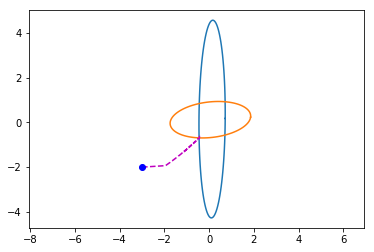

In [180]:
# plot history 
for i in range(n):
    plt.plot(ellipses[i][0,:],ellipses[i][1,:])
plt.plot(history_x[0,:],history_x[1,:],'m--')
plt.plot(x[0,0],x[1,0],'b.',markersize=12)
plt.axis('equal') ; 

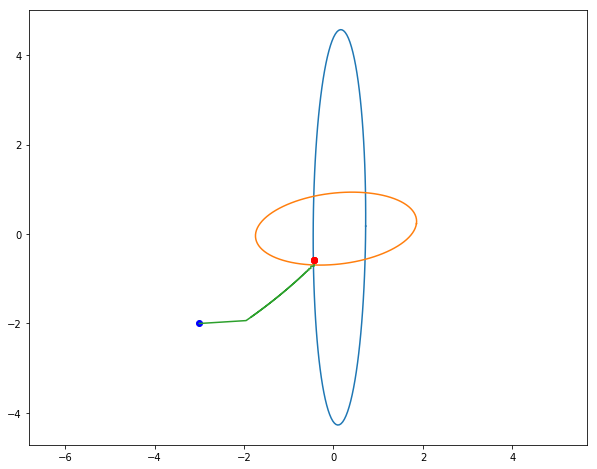

In [181]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
for i in range(n):
    ax.plot(ellipses[i][0,:],ellipses[i][1,:])
ax.plot(x[0,0],x[1,0],'b.',markersize=12)
ax.axis('equal')   
plot_axes = ax.plot([],[])[0]
projected_lines = [ax.plot([],[],'r--.',markersize=12)[0] for _ in range(n)]
# make an initialization
x_copy = x.copy()

def update_frame(frame):
    global x_copy
    directions = calculate_direction(x_copy,A,b)
    x_copy = update_x(x_copy,directions , step_size)
    xData , yData = plot_axes.get_xdata() , plot_axes.get_ydata()
    xData = np.append(xData,x_copy[0,0])
    yData = np.append(yData,x_copy[1,0])
    plot_axes.set_data(xData,yData)
    #plot directions
    for i,local_ax in enumerate(projected_lines):
        u = directions[:,i] + x_copy.reshape(-1)
        local_ax.set_data([u[0],x_copy[0,0]],[u[1],x_copy[1,0]])
        
    return plot_axes,

ani = anim.FuncAnimation(fig,update_frame,range(Max_Iteration),blit=True,interval=30)
HTML(ani.to_html5_video())